# Regrid data to model grid

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
from glob import glob

import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pop_tools
import util

## Setup parameters

In [3]:
src_grid = 'latlon_0_25x0_25_lon180'
dst_grid = 'POP_gx1v7'
method = 'conserve'

clobber = True

get_dst_grid = pop_tools.get_grid

In [4]:
def get_regridder(src_grid, dst_grid, method):

    os.makedirs('data/regridding', exist_ok=True)
    dst_grid_file= f'data/regridding/{dst_grid}.nc'
    src_grid_file = f'data/regridding/{src_grid}.nc'
    weight_file = f'data/regridding/{src_grid}_to_{dst_grid}_{method}.nc'

    if not os.path.exists(src_grid_file) or clobber:
        dso = util.latlon_to_scrip(
            nx=1440, 
            ny=720, 
            lon0=-180., 
            file_out=src_grid_file,
        )
        
    if not os.path.exists(dst_grid_file) or clobber:
        dso = get_dst_grid(dst_grid, scrip=True)
        print(f'writing {dst_grid_file}')
        dso.to_netcdf(dst_grid_file)    
        
    if not os.path.exists(weight_file) or clobber:
        cmd = ['ESMF_RegridWeightGen', '--netcdf4', '--ignore_unmapped',
                    '-s', src_grid_file, '-d', dst_grid_file, '-m', method, '-w', weight_file]
        out = subprocess.run(cmd, capture_output=True, check=True)
        print(out.stdout.decode('UTF-8'))
        
    return util.regridder(src_grid_file, dst_grid_file, weight_file)        

regrid_op = get_regridder(src_grid, dst_grid, method)
regrid_op

writing data/regridding/latlon_0_25x0_25_lon180.nc
writing data/regridding/POP_gx1v7.nc
 Starting weight generation with these inputs: 
   Source File: data/regridding/latlon_0_25x0_25_lon180.nc
   Destination File: data/regridding/POP_gx1v7.nc
   Weight File: data/regridding/latlon_0_25x0_25_lon180_to_POP_gx1v7_conserve.nc
   Source File is in SCRIP format
   Source Grid is a global grid
   Source Grid is a logically rectangular grid
   Use the center coordinates of the source grid to do the regrid
   Destination File is in SCRIP format
   Destination Grid is a global grid
   Destination Grid is a logically rectangular grid
   Use the center coordinates of the destination grid to do the regrid
   Regrid Method: conserve
   Pole option: NONE
   Ignore unmapped destination points
   Output weight file in NetCDF4 file format
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. Method: none

 Completed weight generation successfully.


source grid dims: (720, 1440)
destination grid 

regridder latlon_0_25x0_25_lon180.nc --> POP_gx1v7.nc

In [5]:
files_src = sorted(glob('data/0_25x0_25/*.zarr'))
files_src

['data/0_25x0_25/copepod-2012__cmass-m00-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m01-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m02-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m03-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m04-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m05-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m06-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m07-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m08-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m09-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m10-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m11-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m12-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m13-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m14-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m15-qtr.zarr',
 'data/0_25x0_25/copepod-2012__cmass-m16-qtr.zarr']

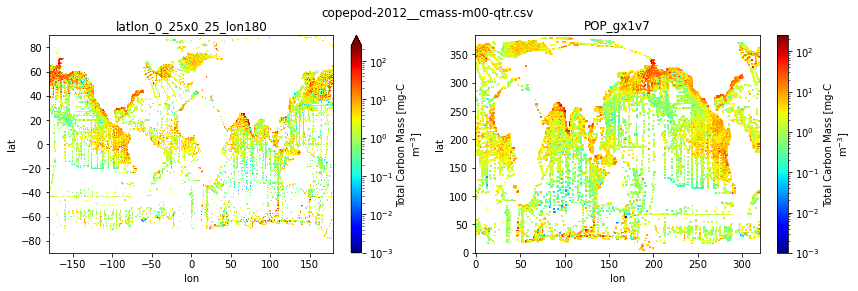

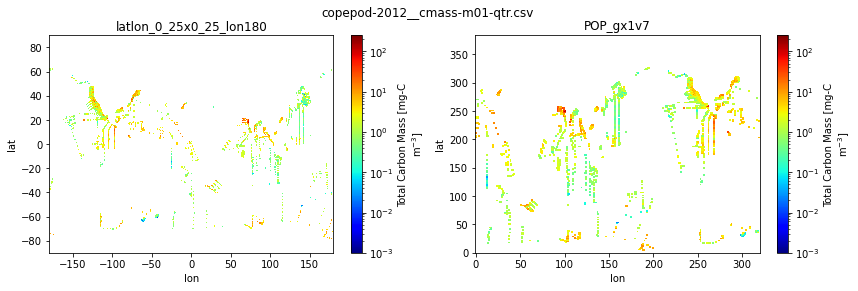

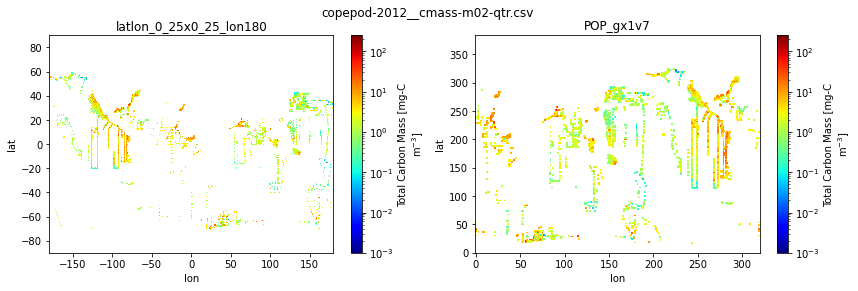

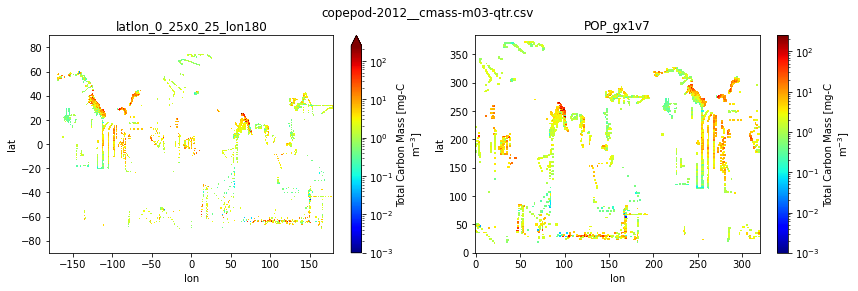

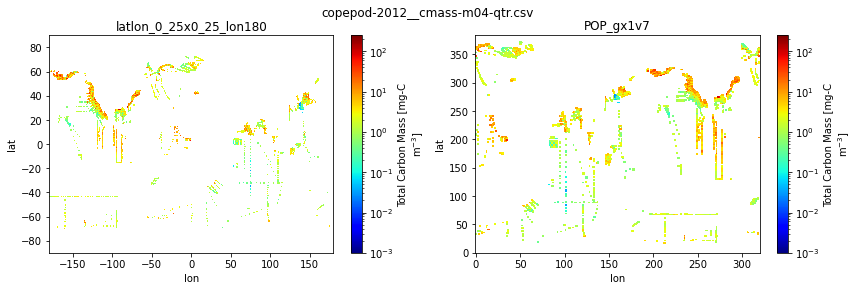

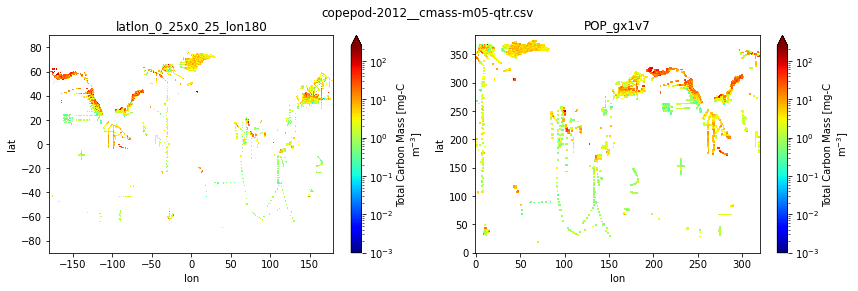

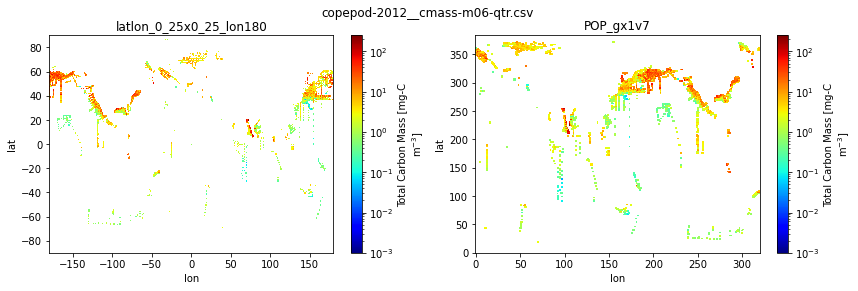

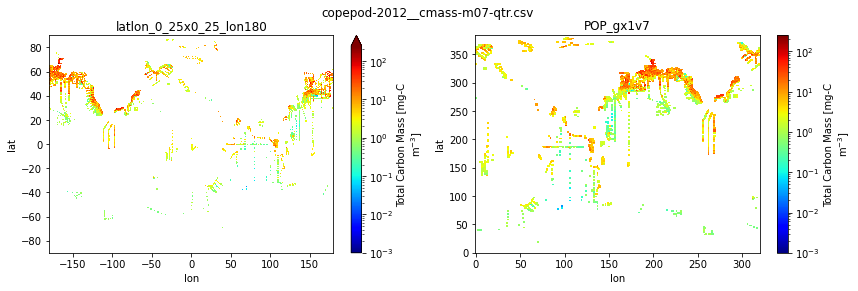

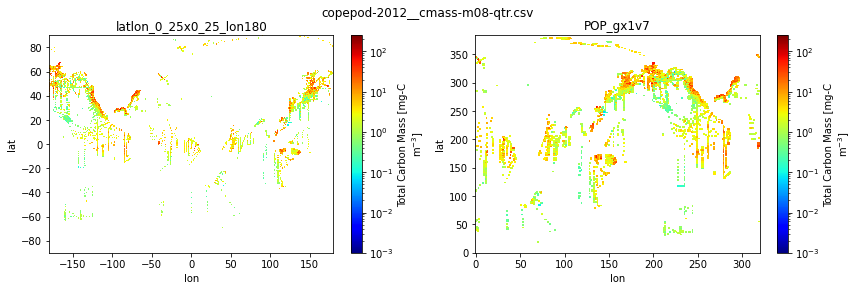

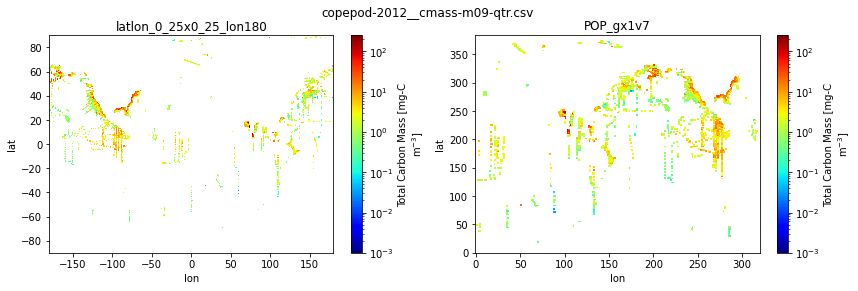

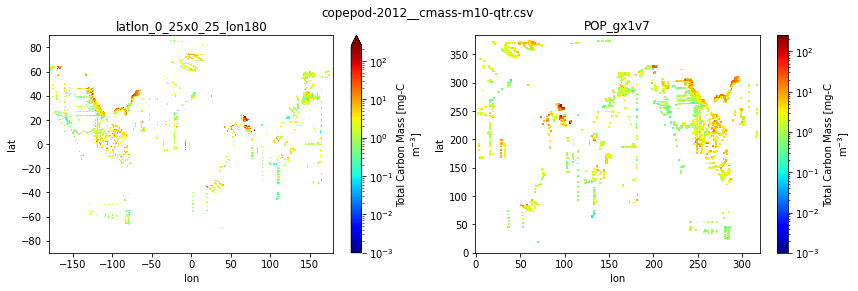

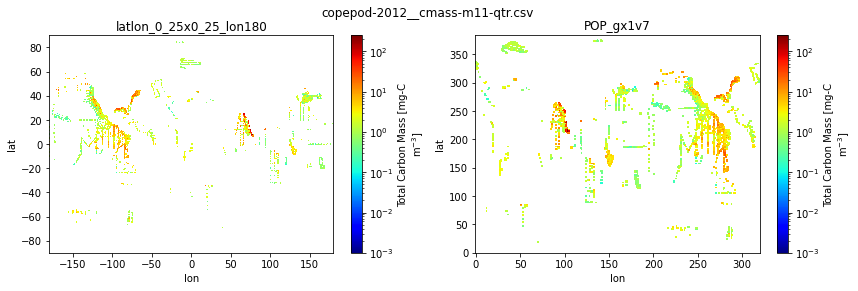

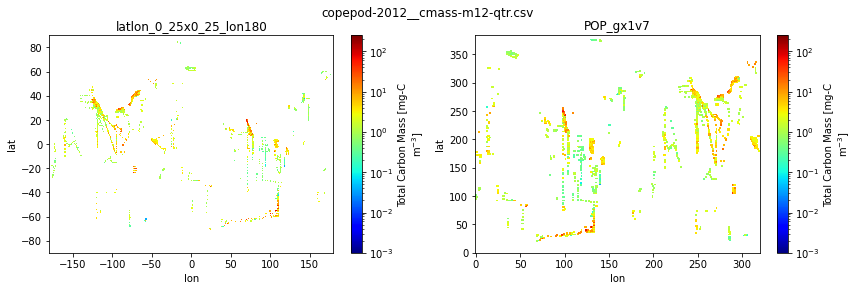

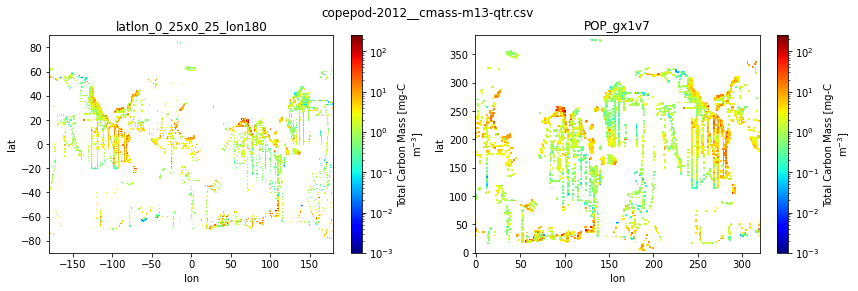

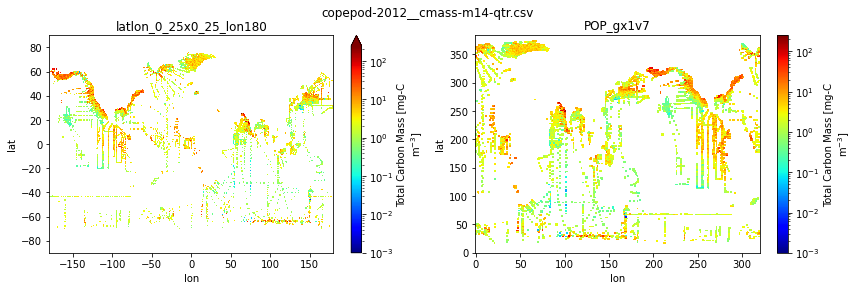

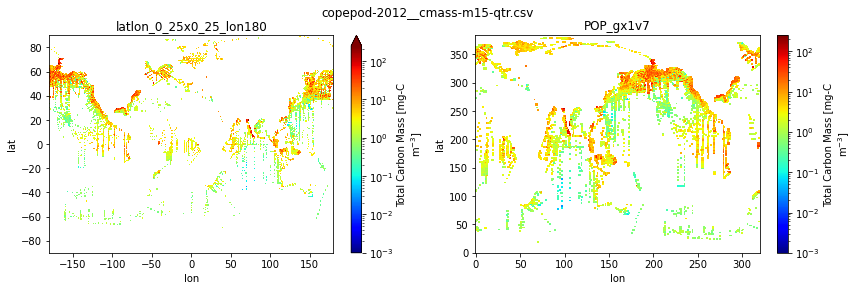

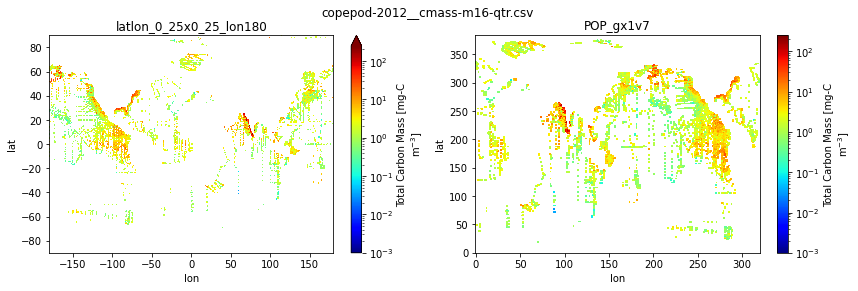

In [6]:
def regrid(ds_src):    
    ds_dst = xr.Dataset()
    for v in ds_src.data_vars:
        ds_dst[v] = regrid_op.regrid_dataarray(
            ds_src[v],
            renormalize=True, 
            apply_mask=True,
        )
        ds_dst[v].attrs = ds_src[v].attrs
        ds_dst.attrs = ds_src.attrs        
    return ds_dst
        
dirout = f'data/{dst_grid}'
os.makedirs(dirout, exist_ok=True)

for file_src in files_src:
    file_dst = f'{dirout}/{os.path.basename(file_src)}'
    ds_src = xr.open_zarr(file_src).compute()
    ds_dst = regrid(ds_src)
    if not os.path.exists(file_dst) or clobber:  
        ds_dst.to_zarr(file_dst, mode='w')    
        
    fig = plt.figure(figsize=(14, 4))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    
    ds_src.copepod_C.plot(
        ax=ax1, 
        norm=colors.LogNorm(vmin=1e-3, vmax=250.),
        cmap='jet',
    )
    ax1.set_title(src_grid)
    
    ds_dst.copepod_C.plot(
        ax=ax2, 
        norm=colors.LogNorm(vmin=1e-3, vmax=250.),
        cmap='jet',
    )
    ax2.set_title(dst_grid)
    fig.suptitle(os.path.basename(ds_src.file_in))